# __CNN Cancer Detection Kaggle Project__

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from sklearn.model_selection import train_test_split
import cv2
import os

In [2]:
# Check to ensure that GPU acceleration is working properly
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


## __The Problem__
The purpose of this project is to create an algorithm capable classifying tissue sample images as cancerous or not, using Convolutional Neural Networks via tensorflow's keras. This would be a very desirable tool in medicine, as it could act as a helpful second opinion to the experienced, or as a guide to the inexperienced.

## __The Data__
The training data available for this problem are images composed of a modified PCam dataset. The dataset is three-channel RGB, containing 220,026 scans of tissue samples, each sized at 96X96 pixels, resulting in a set with 6,083,278,848 values. Accompanying these pictures is a csv file labelled "_labels.csv", which contains the image IDs, and its associated label for cancerous or non-cancerous.

Below I import the images based on the IDs given by the csv document, on the off change that there are some not present.

In [4]:
data_dir = "A:/CNN_project/data/"
train_dir = data_dir + "train/"
test_dir = data_dir + "test/"

train_keys = pd.read_csv(train_dir + "_labels.csv")

images,labels = [],[]

for i,label in enumerate(train_keys["id"].tolist()):
    filename = train_dir + label + ".tif"

    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    images.append(image)

images = np.array(images)

labels = train_keys["label"]

shape of data and total values given below

In [5]:
print("shape of data is: {}".format(np.shape(images)))
print("total values in data is: {}".format(np.prod(np.shape(images))))

shape of data is: (220025, 96, 96, 3)
total values in data is: 1788283904


## Exploratory Data Analysis

The EDA done for this project is mostly done with the purpose of ensuring that image outliers do not interfere with the model's classification. If images are taken in poor lighting conditions, or are just taken poorly, they may negatively affect model's accuracy. For example, if images are overexposed, then the model may begin to associate overexposure with one class or another. As such, analysis will be performed on the RGB color values of images.

Below I order the data into new variables, based on color value:
- all_values_X contains every rgb value for color X
- X_2D flattens 96X96 images into single dimensions, making the entire set 2D, for color X
- avg_X contains each individual image's average RGB value for a particular image for color X
- std_X follows the same convention but for standard deviation, maximum pixel value, and minimum pixel value.

Each metric_X set has the potential to reveal outliers for removal.

In [6]:
all_values_red = images[:,:,:,0]
all_values_green = images[:,:,:,1]
all_values_blue = images[:,:,:,2]

red_2D = all_values_red.reshape(all_values_red.shape[0],-1)
green_2D = all_values_green.reshape(all_values_green.shape[0],-1)
blue_2D = all_values_blue.reshape(all_values_blue.shape[0],-1)

avg_red   = np.mean(red_2D,axis = 1)
avg_green = np.mean(green_2D, axis = 1)
avg_blue  = np.mean(blue_2D, axis = 1)

std_red   = np.std(red_2D,axis = 1)
std_green = np.std(green_2D, axis = 1)
std_blue  = np.std(blue_2D, axis = 1)

To start, let's just get a simple visualization of what the all color values distributions look like

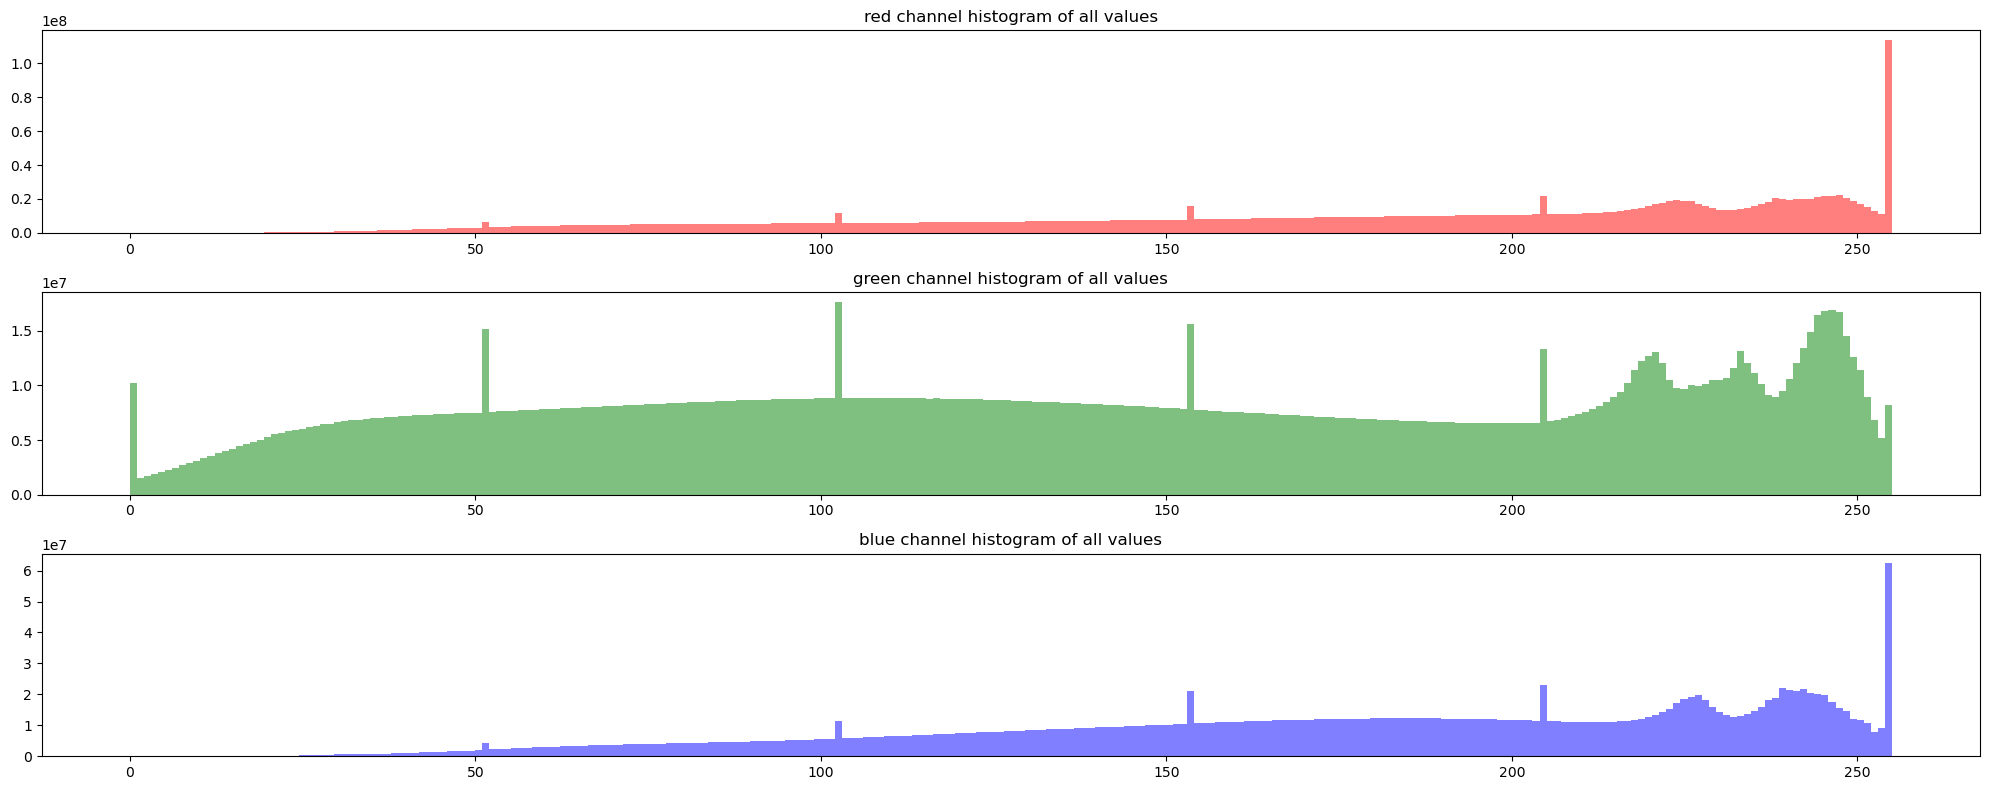

In [7]:
fig,axs = plt.subplots(3,1, figsize = (20,8))
axs[0].hist(all_values_red.flatten(),color = "red", alpha = 0.5, bins = 250)
axs[0].set_title("red channel histogram of all values")
axs[1].hist(all_values_green.flatten(),color = "green",alpha = 0.5, bins = 250)
axs[1].set_title("green channel histogram of all values")
axs[2].hist(all_values_blue.flatten(),color = "blue",alpha = 0.5, bins = 250)
axs[2].set_title("blue channel histogram of all values")
plt.tight_layout()

plt.show()

Nothing seems out of the ordinary, and thanfully this shows that the bulk of the photos are not overexposed, otherwise we would see the histograms tending towards 0 rather than 255.

It's also interesting to see that red has many of it's values outright at the extreme of 255

Below is a plot of the average value per channel of each image. While they do look fine for the most part, it is concerning that there are some entries for red and blue below 50, which is a sign of overexposure. This is less concerning for the green channel since the tail of the bulk distribution clearly already extends that far. Zoomed in plots are needed.

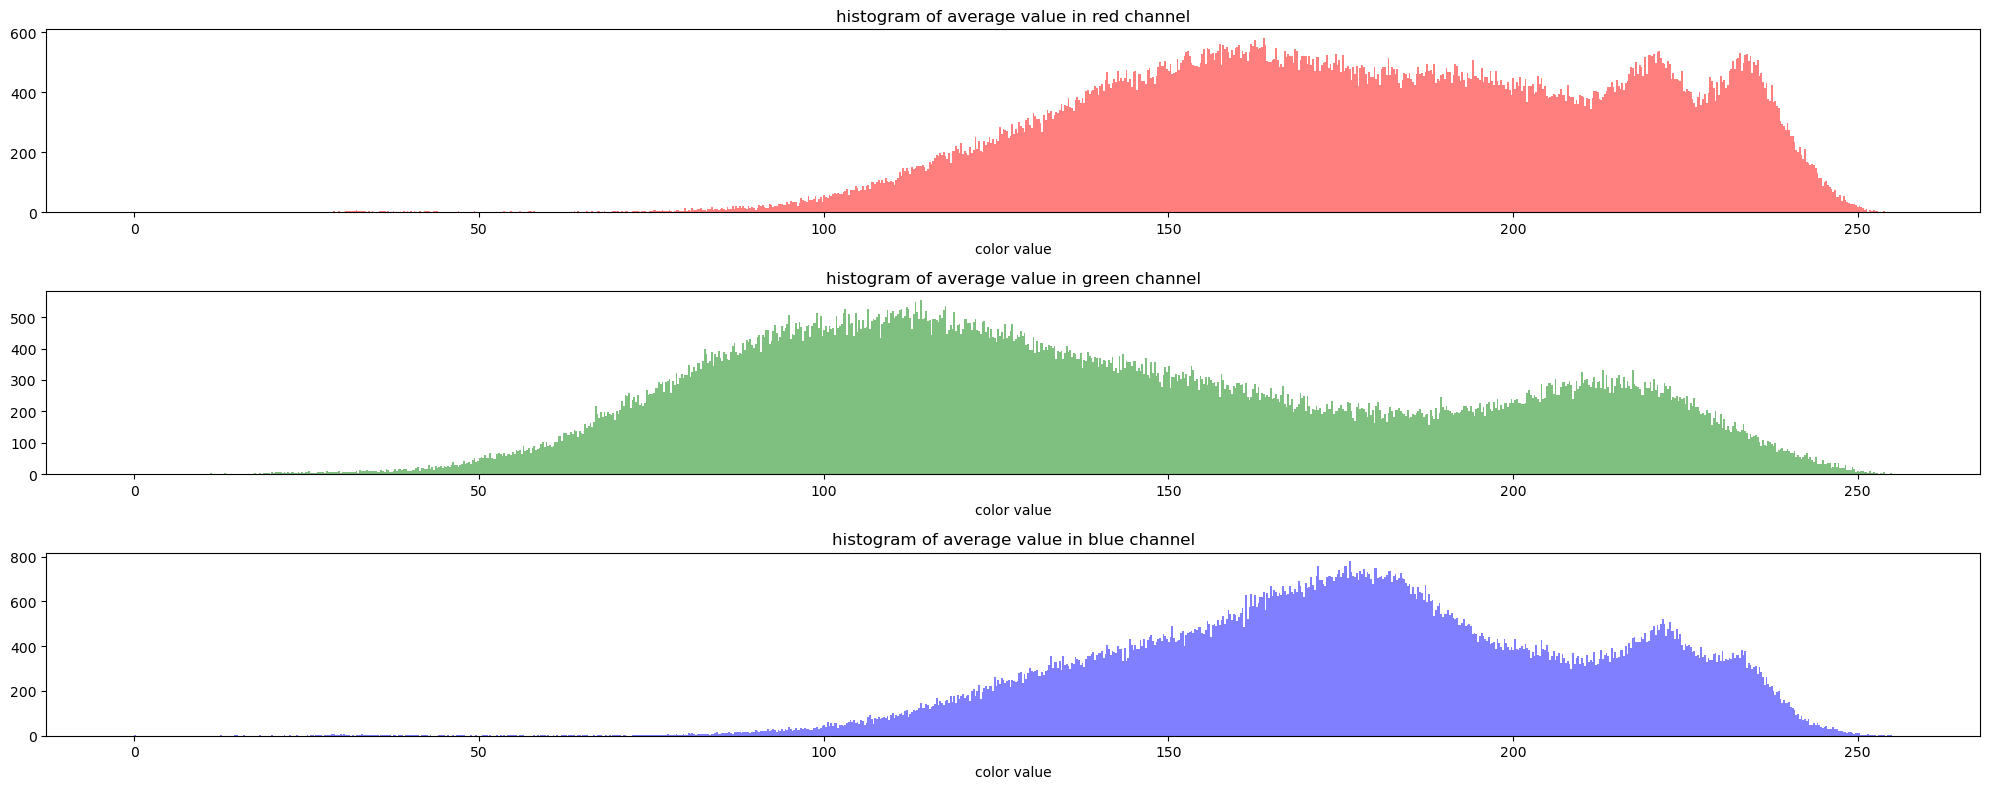

In [8]:
fig,axs = plt.subplots(3,1, figsize = (20,8))
axs[0].hist(avg_red,color = "red", alpha = 0.5, bins = 1000)
axs[1].hist(avg_green,color = "green",alpha = 0.5, bins = 1000)
axs[2].hist(avg_blue,color = "blue",alpha = 0.5, bins = 1000)

axs[0].set_title("histogram of average value in red channel")
axs[1].set_title("histogram of average value in green channel")
axs[2].set_title("histogram of average value in blue channel")

for i in range(3):
    axs[i].set_xlabel("color value")

plt.tight_layout()
plt.show()

Zoomed in plots of the areas in question, with a line for the to be imposed cutoff.

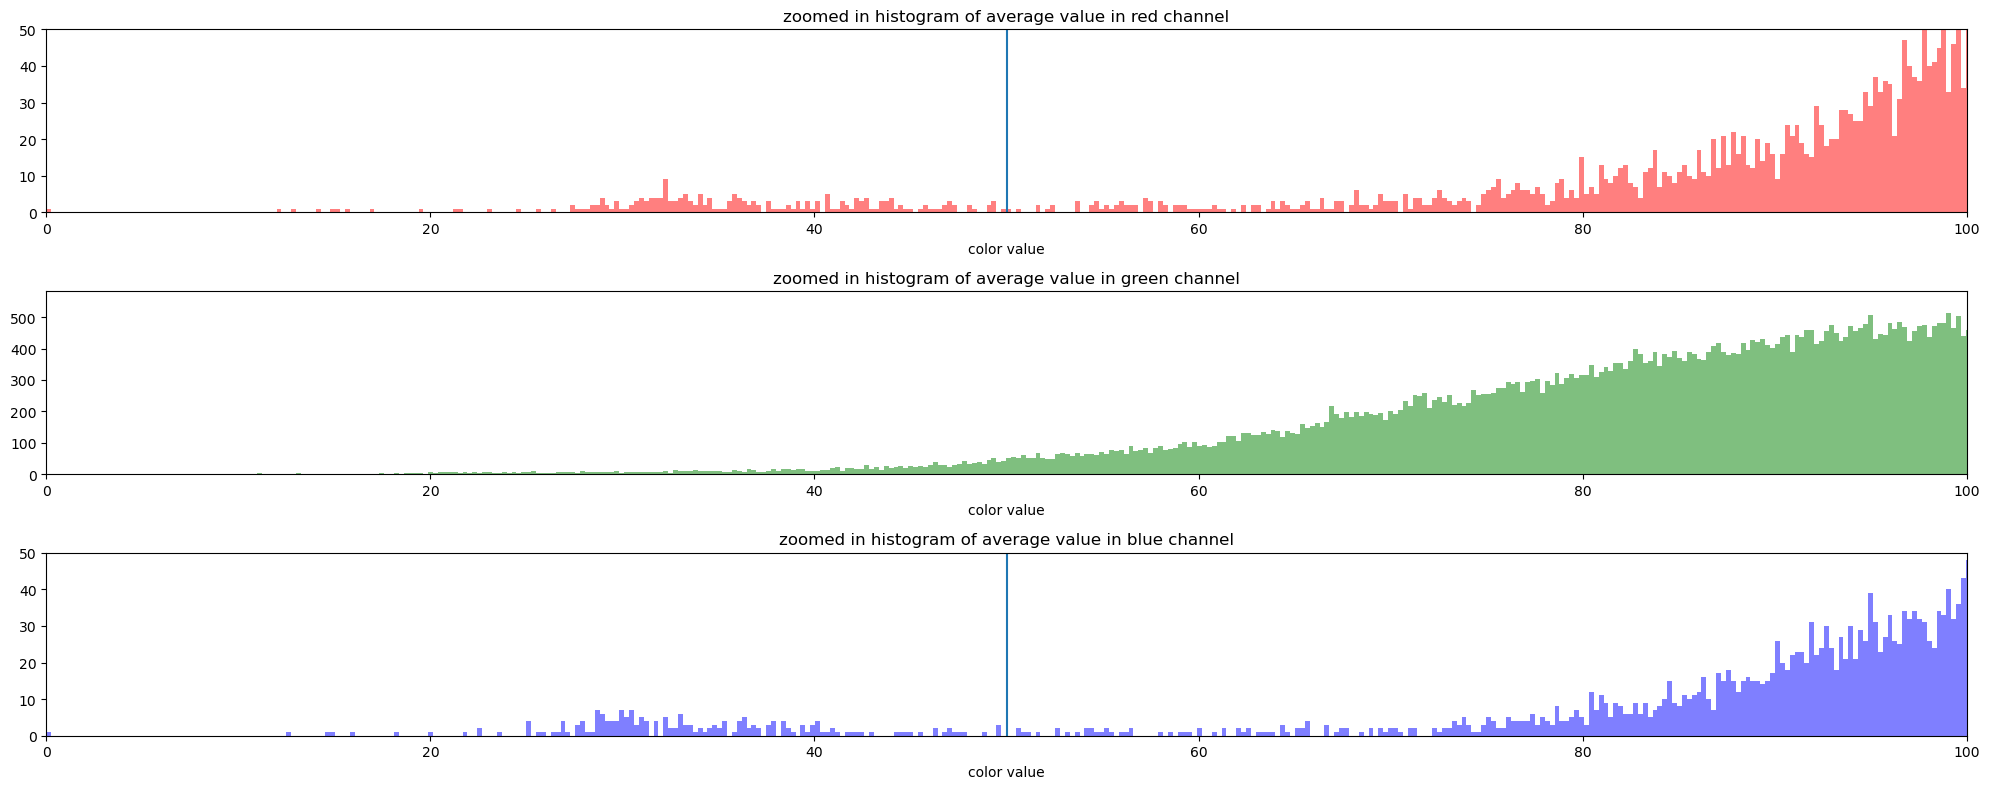

In [9]:
fig,axs = plt.subplots(3,1, figsize = (20,8))

axs[0].hist(avg_red,color = "red", alpha = 0.5, bins = 1000)
axs[0].set_xlim(0,100)
axs[0].set_ylim(0,50)
axs[1].hist(avg_green,color = "green",alpha = 0.5, bins = 1000)
axs[1].set_xlim(0,100)
axs[2].hist(avg_blue,color = "blue",alpha = 0.5, bins = 1000)
axs[2].set_xlim(0,100)
axs[2].set_ylim(0,50)
axs[0].axvline(50)
axs[2].axvline(50)

axs[0].set_title("zoomed in histogram of average value in red channel")
axs[1].set_title("zoomed in histogram of average value in green channel")
axs[2].set_title("zoomed in histogram of average value in blue channel")

for i in range(3):
    axs[i].set_xlabel("color value")

plt.tight_layout()

plt.show()

In [10]:
# removing the outliers
avg_mask = np.logical_and(avg_red > 50, avg_blue > 50)
labels = labels[avg_mask]
images = images[avg_mask]
std_red,std_green,std_blue = std_red[avg_mask],std_green[avg_mask],std_blue[avg_mask]

Below are histograms for images' standard deviations per color channel. While there is a slight bump near zero for each distribution, and could suggest overexposure, I will not remove them, due to the prominence of these within the data. Doing so may remove nuance within the neural network, making it worse at generalizing.

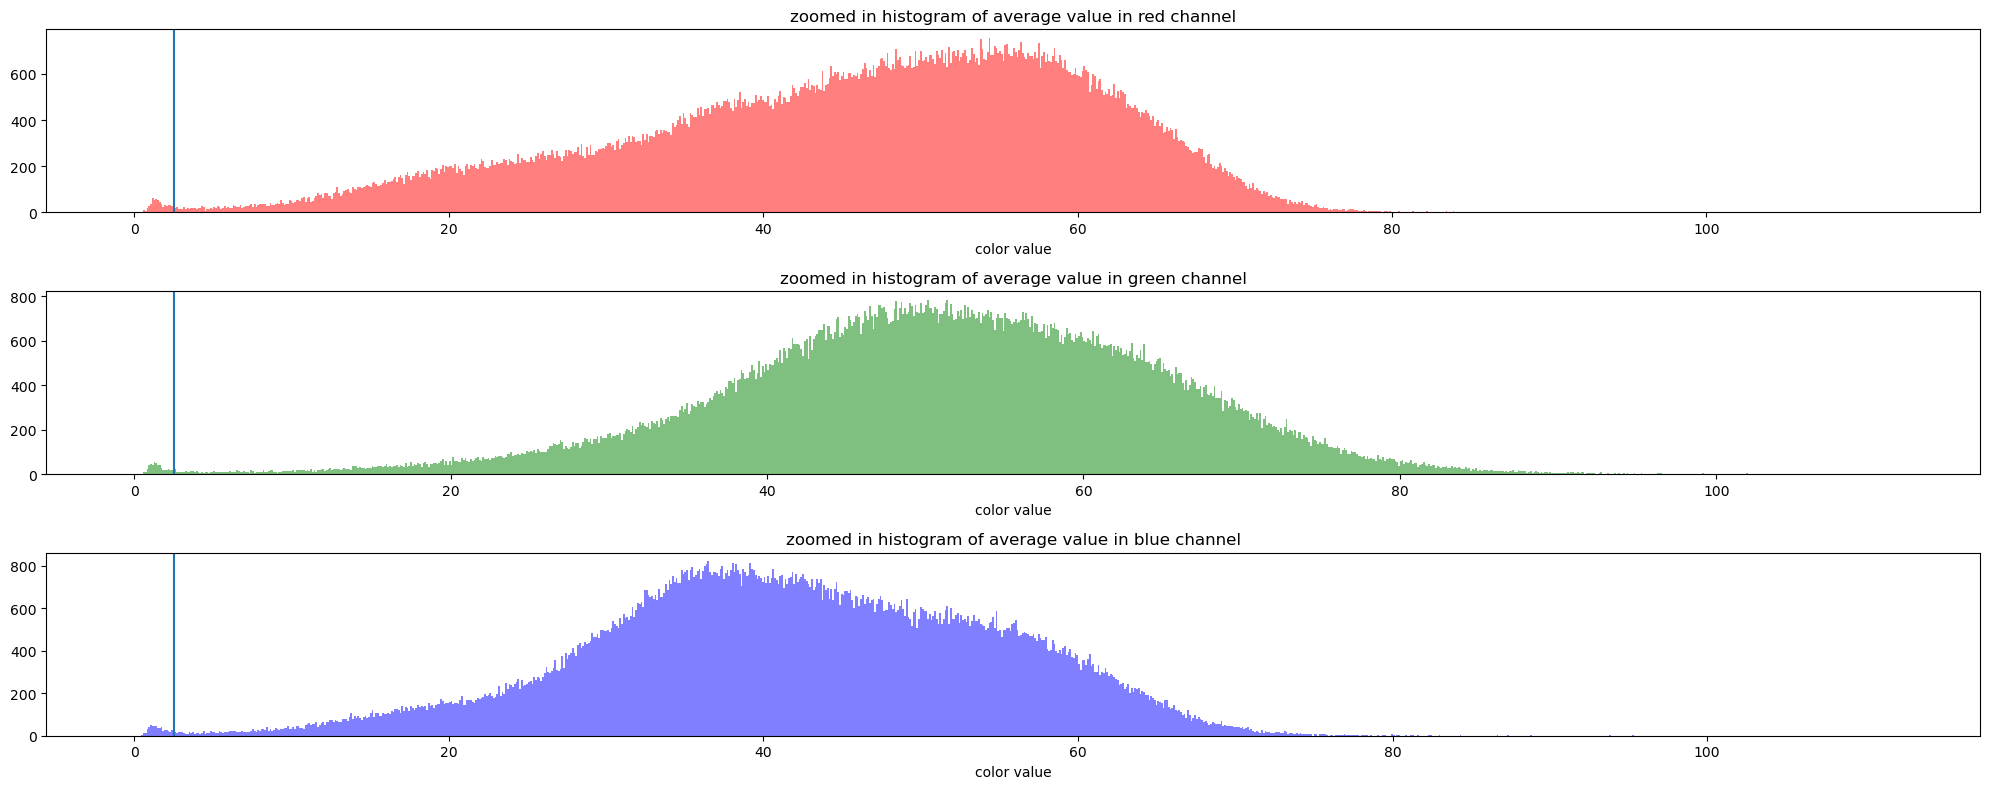

In [11]:
fig,axs = plt.subplots(3,1, figsize = (20,8))
axs[0].hist(std_red,color = "red", alpha = 0.5, bins = 1000)
axs[1].hist(std_green,color = "green",alpha = 0.5, bins = 1000)
axs[2].hist(std_blue,color = "blue",alpha = 0.5, bins = 1000)

axs[0].axvline(2.5)
axs[1].axvline(2.5)
axs[2].axvline(2.5)

axs[0].set_title("zoomed in histogram of average value in red channel")
axs[1].set_title("zoomed in histogram of average value in green channel")
axs[2].set_title("zoomed in histogram of average value in blue channel")

for i in range(3):
    axs[i].set_xlabel("color value")

plt.tight_layout()
    
plt.show()

In [12]:
#removing further outliers
std_mask = np.logical_and(std_red > 2.5, std_blue > 2.5,std_green > 2.5)
labels = labels[std_mask]
images = images[std_mask]

## Model Architecture:


__The Optimized Model__

Below is the model I optimized for this problem. It utilizes four Convolutional "Blocks", each composed of two convolutional layers, and one maxpooling layer. By having a maxpooling layer at the end of each block, it reduces the spatial feature space by a factor of 4, allowing me to double the filter feature space without worry for computational complexity. I kept the filter size as 3X3 to allow for more "convolutional layer blocks" without losing too much feature space.

By doubling the number of filters with each block, the model is able to go deeper, and able to detect finer and finer details within the dataset. One must be careful with the maxpooling reduction however, as too much too soon can completely remove the nuance the later models are trying to detect. Padding is also done to retain dimensions between layers. the documentation also outlines the feature space associated with each layer.


Ultimately this model worked best with a training rate of 0.0001 and 7 epochs. in the code the feature space for each layer is also outlined

In [13]:

def makemodel_final(learning_rate):
    
    model = Sequential()
    
    model.add(Conv2D(25, (3, 3), padding="same", activation='relu', input_shape=(96, 96, 3))) #(96,96,25) 
    model.add(Conv2D(25, (3, 3), padding="same", activation='relu')) #(96,96,25)
    model.add(MaxPooling2D(pool_size=(2,2))) # (48,48,25)

    model.add(Conv2D(50, (3, 3), padding="same", activation='relu')) # (48,48,50)
    model.add(Conv2D(50, (3, 3), padding="same", activation='relu')) # (48,48,50)
    model.add(MaxPooling2D(pool_size=(2,2))) # (24,24,50)

    model.add(Conv2D(100, (3, 3), padding="same", activation='relu')) # (24,24,100)
    model.add(Conv2D(100, (3, 3), padding="same", activation='relu')) # (24,24,100)
    model.add(MaxPooling2D(pool_size=(2, 2))) # (12,12,100)

    model.add(Conv2D(200, (3, 3), padding="same", activation='relu')) # (12,12,200)
    model.add(Conv2D(200, (3, 3), padding="same", activation='relu'))# (12,12,200)
    model.add(MaxPooling2D(pool_size=(2, 2))) # (6,6,200)

    model.add(Flatten()) # (7200)
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model



__The Unoptimized Models__

Below was an earlier attempts at CNN models, and are the first and third iterations in the five-part iteration that led to my final model above.
The first iteration uses 3x3 filters (no padding) and (2,2) strides as the means of spatial feature reduction. It also has a structure of doubling the filters with each layer, but only does so for 50,100,and 200. It performs respectably, but I thought it could do better, so I made the one shown before this.

The second iteration is closer to the final result, now utilizing padding and maxpool layers, and adds the 25-filter Convolution block.

In [14]:
def makemodel_first(learning_rate):
    model = Sequential()
    

    model.add(Conv2D(50, (3, 3), strides = (2,2), activation='relu', input_shape=(96, 96, 3)))
    model.add(Conv2D(100, (3, 3), strides = (2,2), activation='relu'))
    model.add(Conv2D(200, (3, 3), strides = (2,2), activation='relu'))


    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


Below is another unoptimized model, now utilizing padding and maxpool layers, and adds the 25-filter Convolution block

In [15]:
def makemodel_third(learning_rate):
    
    model = Sequential()
    
    model.add(Conv2D(25, (3, 3), padding="same", activation='relu', input_shape=(96, 96, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(50, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(100, (3, 3), padding="same", activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    model.add(Conv2D(200, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
              
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Results and Analysis

While I cannot show each and every iteration due to VRAM limitations, I can show three of them. Below are the architectural changes culminating in each model improving in validation performance over the last.

First -> Third: Padding and maxpool, stride removed

Third -> Final: Extra Convolutional layer per block, dropout layer added


Below, the models are trained and their validation accuracy is gathered. 
This will be the Primary metric by which I plan on evaluating which model performs the best.

In [16]:
tf.keras.backend.clear_session()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [19]:
a = 0.0001
models = [makemodel_final(a),makemodel_first(a),makemodel_third(a)]
history_list = []
for model in models:
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=10)
    history_list.append(history)

Epoch 1/10
17537/17537 [==============================] - 132s 7ms/step - loss: 0.3999 - accuracy: 0.8244 - val_loss: 0.2870 - val_accuracy: 0.8785
Epoch 2/10
17537/17537 [==============================] - 129s 7ms/step - loss: 0.2581 - accuracy: 0.8961 - val_loss: 0.2440 - val_accuracy: 0.9033
Epoch 3/10
17537/17537 [==============================] - 127s 7ms/step - loss: 0.2072 - accuracy: 0.9198 - val_loss: 0.2075 - val_accuracy: 0.9185
Epoch 4/10
17537/17537 [==============================] - 126s 7ms/step - loss: 0.1763 - accuracy: 0.9334 - val_loss: 0.1790 - val_accuracy: 0.9322
Epoch 5/10
17537/17537 [==============================] - 124s 7ms/step - loss: 0.1544 - accuracy: 0.9429 - val_loss: 0.1991 - val_accuracy: 0.9263
Epoch 6/10
17537/17537 [==============================] - 125s 7ms/step - loss: 0.1363 - accuracy: 0.9497 - val_loss: 0.1514 - val_accuracy: 0.9439
Epoch 7/10
17537/17537 [==============================] - 125s 7ms/step - loss: 0.1221 - accuracy: 0.9557 - val_

This is a plot of their training accuracies by epoch. It's interesting to notice that the training accuracy for the first architecture converges faster than either the third or final one, and the final model's training accuracy looks fairly similar to the third's save for an offset.

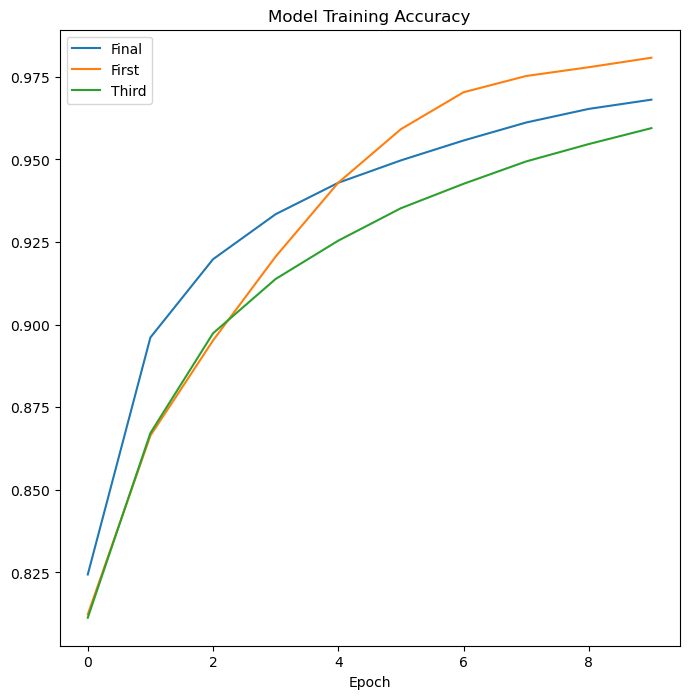

In [20]:
plt.figure(figsize = (8,8))
plt.title("Model Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel
for history in history_list:
    plt.plot(history.history["accuracy"])

plt.legend(["Final","First","Third"])

Below are plots of the model validation accuracy per epoch. Interestingly, all model's validation accuracy outdo their respective training accuracies for a little bit at the start. Eventually however, the growth of the validation accuracies vanish. 

The final model proves to be the best, but also the least stable. Despite my best efforts to choose a better learning rate, its validation accuracy begins to waver as it approaches 94%.

The third model improved upon the first model, and appears (in this plot) to be the most stable out of them. Once it reaches its peak validation accuracy, it begins to overfit and worsen

The first model was the worst out of them, but still performed respectably. It seems to converge quickly, but shows stability issues much like the final model.

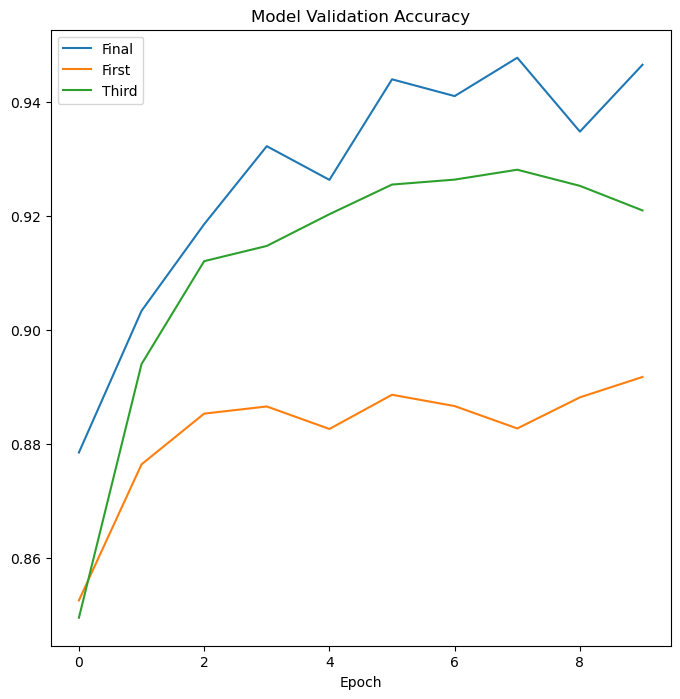

In [21]:
plt.figure(figsize = (8,8))
plt.title("Model Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel
for history in history_list:
    plt.plot(history.history["val_accuracy"])

plt.legend(["Final","First","Third"])

Below I create a table to summarize results

In [39]:
ep = np.arange(1,10,1)
tr_acc = []
va_acc = []
for history in history_list:
    tr_acc.append(history.history["accuracy"])
    va_acc.append(history.history["val_accuracy"])

table = pd.DataFrame({},columns=ep)
table = table.append(tr_acc)
table = table.append(va_acc)
accuracy_metrics = ["final_train","first_train","third_train","final_valid","first_valid","third_valid"]
table["Accuracy metrics"] = accuracy_metrics
#plt.legend(["Final","First","Third"])

C:\Users\Angel\AppData\Local\Temp\ipykernel_29752\891318714.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(tr_acc)
C:\Users\Angel\AppData\Local\Temp\ipykernel_29752\891318714.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(va_acc)


Below is the result summary table for train and test accuracies based on the model's epoch (for some reason it kept registering 10 as 0).

The best of these proved to be epoch 7 of the final model, managing to have a validation accuracy of 94.7%, which is very promising.

In [41]:
table

,1,2,3,4,5,6,7,8,9,0,Accuracy metrics
0,0.896102,0.919790,0.933424,0.942936,0.949710,0.955726,0.961172,0.965295,0.968089,0.824365,final_train
1,0.866392,0.895201,0.920605,0.942959,0.959159,0.970330,0.975251,0.977909,0.980783,0.812288,first_train
2,0.867162,0.897373,0.913814,0.925412,0.935232,0.942617,0.949391,0.954649,0.959467,0.811278,third_train
0,0.903332,0.918524,0.932210,0.926302,0.943934,0.940991,0.947720,0.934764,0.946488,0.878493,final_test
1,0.876417,0.885313,0.886567,0.882621,0.888620,0.886636,0.882713,0.888164,0.891745,0.852558,first_test
2,0.894003,0.912046,0.914715,0.920280,0.925481,0.926347,0.928081,0.925253,0.920942,0.849524,third_test


Generally, with each new technique applied thoughtfully, the model did improve. The ones that seemed to have the largest effect on the performance seemed to be the addition of maxpool layers, and the addition of extra convolutional layers per block.

Some of the not-so compatible techniques for this particular CNN were stride, larger filters, as well as further block layers beyond the second one, which are omitted. 

I should also mention that the greatest challenge I had with this project was tensorflow's VRAM allocation, which I had to work around. I wanted to create and outright compare a wider array of well-performing models, but the only version of tensorflow I got working with GPU acceleration does not reset VRAM between model training, despite my best efforts. As such, I was limited to only three models, all of which could fit on 24Gb of VRAM. If anyone has any suggestions or recommendations to fix this please let me know.

## __Conclusion__

Ultimately, I was quite happy with how my results turned out. I was able to iteratively improve my CNN model by modifying its architecture, culminating in a model with a 94.7% validation test accuracy. When submitted to kaggle, it gave an 83% private score and a 87% public score.

I was most suprised by how well the continual addition of maxpool layers improved the network, since my intuition said that enough pooling layers would hurt the model, by lowering the amount of information that the high-filter Convolutional layers had access to. As it turned out, it greatly helped the model, by allowing the high filter layers to be feasibly trained within a reasonable time frame, without tanking their performance. 

Improvements I could try in the future would be to look more into the proper addition of 1x1 convolutional layers, as I did briefly try implementing them, but gave up fairly early on in the process. THey seem to do well at capturing very specific details, which could be the nuance needed to take the model even further. I would also like to try and improve upon the stability of the model, which seemed to vary a lot compared to the others.

This is just the code I used for exporting that one model's results to the kaggle competition.

In [43]:
#imports the kaggle test dataset
test_keys = os.listdir(test_dir)

id_names = []
test_images = []

for label in test_keys:
    filename = test_dir + label 

    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    id_names.append(label[:-4])
    test_images.append(image)

test_images = np.array(test_images)

Below is the code I used for my final model trained to 7 epochs to create predictions for the kaggle competition.

In [ ]:
batch_size = 5000
tot_images = len(test_images)
predictions = []

for i in range(0,tot_images,batch_size):
    batch = test_images[i:i+batch_size]
    batch_pred = model_optimized.predict(batch)
    predictions.append(batch_pred)

predictions = np.concatenate(predictions)
predictions = np.round(np.array(predictions).flatten())


77/77 [==============================] - 0s 2ms/step


In [ ]:
dict = {"id":id_names,"label" : predictions}
df = pd.DataFrame(dict)
df.to_csv(data_dir + "predictions.csv", index=False)